In [ ]:
!pip install snowflake

In [ ]:
!pip install snowflake-ml-python

In [ ]:
!pip install snowflake-snowpark-python

In [ ]:
!pip install python-dotenv

In [ ]:
!pip install llama-index-embeddings-huggingface

# Connect to Snowflake

In [6]:
import os

In [7]:
from google.colab import userdata  # for Google Colab authentication
from snowflake.snowpark.session import Session

connection_params = {
    "account": userdata.get('SNOWFLAKE_ACCOUNT'),
    "user": userdata.get('SNOWFLAKE_USER'),
    "password": userdata.get('SNOWFLAKE_USER_PASSWORD'),
    "role": userdata.get('SNOWFLAKE_ROLE'),
    "database": userdata.get('SNOWFLAKE_DATABASE'),
    "schema": userdata.get('SNOWFLAKE_SCHEMA'),
    "warehouse": userdata.get('SNOWFLAKE_WAREHOUSE')
}
snowpark_session = Session.builder.configs(connection_params).create()

In [8]:
snowpark_session

Test CORTEX LLM

In [9]:
from snowflake.cortex import complete

print(complete("mistral-large2", "how do snowflakes get their unique patterns?"))

 Snowflakes get their unique patterns through a complex process of crystallization that occurs as they form in the atmosphere. Here's a simplified explanation:

1. **Nucleation**: Snowflakes begin to form when a tiny particle in the atmosphere, such as a speck of dust, acts as a nucleus for ice crystals to grow around.

2. **Crystal Growth**: As the nucleus travels through the cloud, it encounters water vapor that freezes onto it, forming a tiny hexagonal prism of ice. This is the basic structure of a snowflake, which has six sides due to the molecular structure of water.

3. **Branching**: As the ice crystal grows, the six corners of the hexagon become unstable and start to branch out, forming the intricate arms of the snowflake. The exact pattern of this branching depends on the temperature and humidity conditions in the cloud.

4. **Unique Growth**: Each snowflake follows a unique path through the cloud, encountering slightly different conditions. This is why no two snowflakes are e

# Import Text-to-SQL Dataset from Hugging Face (Public)

- Source: https://huggingface.co/datasets/gretelai/synthetic_text_to_sql

In [10]:
import pandas as pd

splits = {'train': 'synthetic_text_to_sql_train.snappy.parquet', 'test': 'synthetic_text_to_sql_test.snappy.parquet'}
df = pd.read_parquet("hf://datasets/gretelai/synthetic_text_to_sql/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
df

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro..."
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...
...,...,...,...,...,...,...,...,...,...,...,...
99995,89651,nonprofit,"Nonprofit data on charitable giving trends, so...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",Which programs had the highest volunteer parti...,"CREATE TABLE programs (program_id INT, num_vol...","SELECT program_id, (num_volunteers / total_par...",This query calculates the participation rate f...
99996,89652,retail,"Retail data on circular supply chains, ethical...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the number of fair-trade certified acc...,"CREATE TABLE products (product_id INT, product...",SELECT COUNT(*) FROM products WHERE is_fair_tr...,The query counts the number of fair-trade cert...
99997,89653,fitness industry,"Workout data, membership demographics, wearabl...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",Find the user with the longest workout session...,"CREATE TABLE workout_sessions (id INT, user_id...","SELECT u.name, MAX(session_duration) as max_du...",The query joins the workout_sessions and users...
99998,89654,space exploration,"Spacecraft manufacturing data, space mission r...",single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",How many space missions were completed by each...,"CREATE TABLE SpaceMissions (id INT, astronaut_...","SELECT a.name, COUNT(sm.id) FROM Astronauts a ...",This query calculates the number of space miss...


# Convert to specific Snowflake's SQL

In [41]:
import re
from typing import Dict, List

class SQLToSnowflakeConverter:
    def __init__(self):
        self.function_mappings = {
            'NOW()': 'CURRENT_TIMESTAMP()',
            'CURRENT_DATE()': 'CURRENT_DATE()',
            'SUBSTR': 'SUBSTRING',
            'LENGTH': 'LEN',
            'CONCAT': '||',  # Snowflake supports both CONCAT and ||
            'UNIX_TIMESTAMP': 'UNIX_TIMESTAMP()',
            'DATE_FORMAT': 'TO_CHAR',
            'STR_TO_DATE': 'TO_DATE',
            'GROUP_CONCAT': 'LISTAGG'
        }

        self.datatype_mappings = {
            'VARCHAR\\(': 'VARCHAR(',
            'INT\\(\\d+\\)': 'INTEGER',
            'DATETIME': 'TIMESTAMP_NTZ',
            'DOUBLE': 'FLOAT',
            'BOOL': 'BOOLEAN',
            'TEXT': 'STRING'
        }

    def convert_query(self, sql: str) -> str:
        """Convert a standard SQL query to Snowflake SQL"""
        converted_sql = sql

        for old_type, new_type in self.datatype_mappings.items():
            converted_sql = re.sub(old_type, new_type, converted_sql, flags=re.IGNORECASE)

        for old_func, new_func in self.function_mappings.items():
            converted_sql = re.sub(r'\b' + old_func + r'\b', new_func, converted_sql, flags=re.IGNORECASE)

        converted_sql = self._handle_date_operations(converted_sql)
        converted_sql = self._handle_string_operations(converted_sql)
        converted_sql = self._handle_table_operations(converted_sql)

        return converted_sql

    def _handle_date_operations(self, sql: str) -> str:
        """Handle date-related operations"""
        sql = re.sub(
            r'DATE_SUB\((.*?),\s*INTERVAL\s*(\d+)\s*(DAY|MONTH|YEAR)S?\)',
            r'DATEADD(\3, -\2, \1)',
            sql,
            flags=re.IGNORECASE
        )
        sql = re.sub(
            r'DATE_ADD\((.*?),\s*INTERVAL\s*(\d+)\s*(DAY|MONTH|YEAR)S?\)',
            r'DATEADD(\3, \2, \1)',
            sql,
            flags=re.IGNORECASE
        )

        sql = re.sub(
            r"DATE_FORMAT\((.*?),\s*'%Y-%m-%d'\)",
            r"TO_CHAR(\1, 'YYYY-MM-DD')",
            sql,
            flags=re.IGNORECASE
        )

        return sql

    def _handle_string_operations(self, sql: str) -> str:
        """Handle string operations"""
        sql = re.sub(
            r'CONCAT\((.*?),(.*?)\)',
            r'(\1 || \2)',
            sql,
            flags=re.IGNORECASE
        )

        return sql

    def _handle_table_operations(self, sql: str) -> str:
        """Handle table operations"""
        sql = re.sub(
            r'CREATE TABLE IF NOT EXISTS',
            r'CREATE TABLE IF NOT EXISTS',
            sql,
            flags=re.IGNORECASE
        )

        sql = re.sub(
            r'AUTO_INCREMENT',
            r'AUTOINCREMENT',
            sql,
            flags=re.IGNORECASE
        )

        return sql

def convert_dataframe_queries(df: pd.DataFrame) -> pd.DataFrame:
    """Convert all SQL queries in a DataFrame to Snowflake SQL"""
    converter = SQLToSnowflakeConverter()

    snowflake_df = df.copy()

    # Convert the SQL queries
    snowflake_df['snowflake_sql'] = snowflake_df['sql'].apply(converter.convert_query)

    return snowflake_df

In [13]:
snowflake_df = convert_dataframe_queries(df)

# Print a sample comparison
for i in range(3):  # Show first 3 examples
    print(f"\nExample {i+1}:")
    print("Original SQL:")
    print(df['sql'].iloc[i])
    print("\nSnowflake SQL:")
    print(snowflake_df['snowflake_sql'].iloc[i])
    print("-" * 80)


Example 1:
Original SQL:
SELECT salesperson_id, name, SUM(volume) as total_volume FROM timber_sales JOIN salesperson ON timber_sales.salesperson_id = salesperson.salesperson_id GROUP BY salesperson_id, name ORDER BY total_volume DESC;

Snowflake SQL:
SELECT salesperson_id, name, SUM(volume) as total_volume FROM timber_sales JOIN salesperson ON timber_sales.salesperson_id = salesperson.salesperson_id GROUP BY salesperson_id, name ORDER BY total_volume DESC;
--------------------------------------------------------------------------------

Example 2:
Original SQL:
SELECT equipment_type, SUM(maintenance_frequency) AS total_maintenance_frequency FROM equipment_maintenance GROUP BY equipment_type;

Snowflake SQL:
SELECT equipment_type, SUM(maintenance_frequency) AS total_maintenance_frequency FROM equipment_maintenance GROUP BY equipment_type;
--------------------------------------------------------------------------------

Example 3:
Original SQL:
SELECT COUNT(*) FROM marine_species WHERE 

In [14]:
snowflake_df.head()

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation,snowflake_sql
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro...","SELECT salesperson_id, name, SUM(volume) as to..."
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...,"SELECT equipment_type, SUM(maintenance_frequen..."
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...,SELECT COUNT(*) FROM marine_species WHERE loca...
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...,"SELECT trader_id, stock, SUM(price * quantity)..."
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...,"SELECT type, cost FROM (SELECT type, cost, ROW..."


In [15]:
snowflake_df['domain'].value_counts()

,count
domain,
ethical fashion,1368
cybersecurity,1360
rural development,1357
hospitality,1296
sustainable infrastructure,1266
...,...
fine arts,707
startups,703
cannabis industry,648


In [16]:
snowflake_df['sql_complexity'].value_counts()

,count
sql_complexity,
basic SQL,48466
aggregation,22015
single join,14932
subqueries,6719
window functions,3596
multiple_joins,2949
set operations,1050
CTEs,273


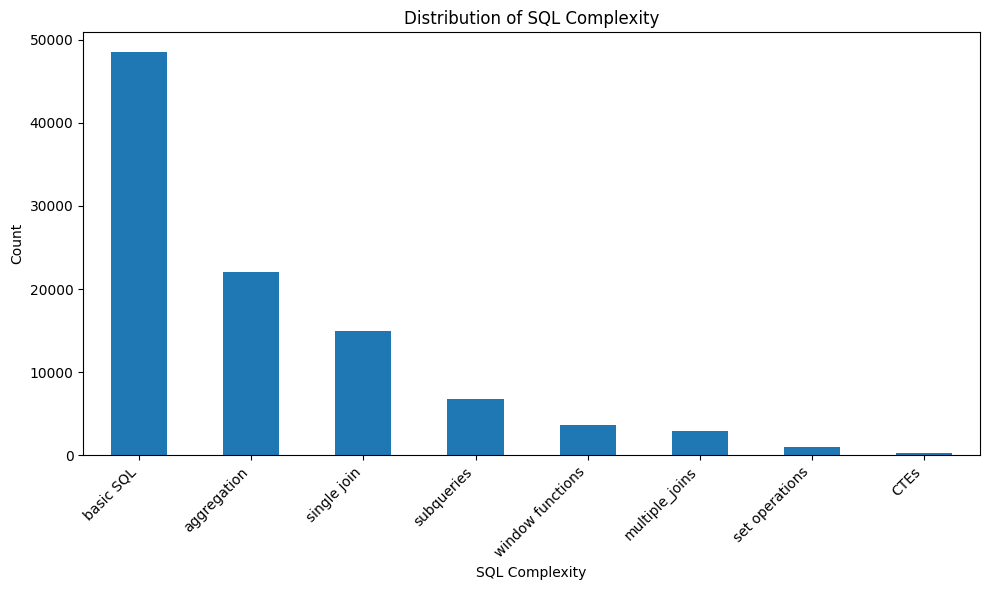

In [17]:
# prompt: plot snowflake_df['sql_complexity'].value_counts()

import matplotlib.pyplot as plt

# Assuming snowflake_df is already defined from the previous code
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
snowflake_df['sql_complexity'].value_counts().plot(kind='bar')
plt.title('Distribution of SQL Complexity')
plt.xlabel('SQL Complexity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [18]:
snowflake_df['sql_task_type'].value_counts()

,count
sql_task_type,
analytics and reporting,88186
data manipulation,9665
data retrieval,1309
data definition,840


In [19]:
snowflake_df.head()

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation,snowflake_sql
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro...","SELECT salesperson_id, name, SUM(volume) as to..."
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...,"SELECT equipment_type, SUM(maintenance_frequen..."
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...,SELECT COUNT(*) FROM marine_species WHERE loca...
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...,"SELECT trader_id, stock, SUM(price * quantity)..."
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...,"SELECT type, cost FROM (SELECT type, cost, ROW..."


In [20]:
pd.set_option('display.max_colwidth', None)

In [21]:
snowflake_df['sql_context'].head()

,sql_context
0,"CREATE TABLE salesperson (salesperson_id INT, name TEXT, region TEXT); INSERT INTO salesperson (salesperson_id, name, region) VALUES (1, 'John Doe', 'North'), (2, 'Jane Smith', 'South'); CREATE TABLE timber_sales (sales_id INT, salesperson_id INT, volume REAL, sale_date DATE); INSERT INTO timber_sales (sales_id, salesperson_id, volume, sale_date) VALUES (1, 1, 120, '2021-01-01'), (2, 1, 150, '2021-02-01'), (3, 2, 180, '2021-01-01');"
1,"CREATE TABLE equipment_maintenance (equipment_type VARCHAR(255), maintenance_frequency INT);"
2,"CREATE TABLE marine_species (name VARCHAR(50), common_name VARCHAR(50), location VARCHAR(50));"
3,"CREATE TABLE trade_history (id INT, trader_id INT, stock VARCHAR(255), price DECIMAL(5,2), quantity INT, trade_time TIMESTAMP);"
4,"CREATE TABLE upgrades (id INT, cost FLOAT, type TEXT); INSERT INTO upgrades (id, cost, type) VALUES (1, 500, 'Insulation'), (2, 1000, 'HVAC'), (3, 1500, 'Lighting');"


In [22]:
snowflake_df['sql'].head()

,sql
0,"SELECT salesperson_id, name, SUM(volume) as total_volume FROM timber_sales JOIN salesperson ON timber_sales.salesperson_id = salesperson.salesperson_id GROUP BY salesperson_id, name ORDER BY total_volume DESC;"
1,"SELECT equipment_type, SUM(maintenance_frequency) AS total_maintenance_frequency FROM equipment_maintenance GROUP BY equipment_type;"
2,SELECT COUNT(*) FROM marine_species WHERE location = 'Southern Ocean';
3,"SELECT trader_id, stock, SUM(price * quantity) as total_trade_value, AVG(price) as avg_price FROM trade_history GROUP BY trader_id, stock;"
4,"SELECT type, cost FROM (SELECT type, cost, ROW_NUMBER() OVER (ORDER BY cost DESC) as rn FROM upgrades) sub WHERE rn = 1;"


In [23]:
from sklearn.model_selection import train_test_split

_, snowflake_df = train_test_split(
    snowflake_df,
    test_size=0.1,
    random_state=42,
    stratify=snowflake_df[['sql_task_type', 'sql_complexity']]
)

print("Test set size:", len(snowflake_df))

Test set size: 10000


In [24]:
snowflake_df.head()

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation,snowflake_sql
47131,68280,cosmetics,"Consumer preference data, ingredient sourcing information, product safety records, and cruelty-free certification metrics.",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical insights",Find the average price of vegan products launched in 2021.,"CREATE TABLE products (product_id INT, name VARCHAR(255), price DECIMAL(5,2), vegan BOOLEAN, launch_date DATE); INSERT INTO products (product_id, name, price, vegan, launch_date) VALUES (1, 'Lipstick', 15.99, true, '2021-03-15'), (2, 'Eye Shadow', 25.49, false, '2020-06-20'), (3, 'Mascara', 10.99, true, '2021-11-17');",SELECT AVG(price) FROM products WHERE vegan = true AND launch_date BETWEEN '2021-01-01' AND '2021-12-31';,"This query calculates the average price of vegan products launched in 2021. It does so by using the AVG function on the price column, while filtering the rows to only include those where the vegan column is set to true and launch_date is between '2021-01-01' and '2021-12-31'.",SELECT AVG(price) FROM products WHERE vegan = true AND launch_date BETWEEN '2021-01-01' AND '2021-12-31';
26223,12236,mining industry,"Mineral extraction statistics, environmental impact assessments, labor productivity metrics, and geological survey information.",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, MAX, etc.), and HAVING clause",analytics and reporting,"generating reports, dashboards, and analytical insights","What are the top 3 mining companies in terms of environmental impact assessments in South Africa, from 2018 to 2020?","CREATE TABLE CompanyEnvironmentalImpact (year INT, company TEXT, country TEXT, impact_assessment_score INT); INSERT INTO CompanyEnvironmentalImpact (year, company, country, impact_assessment_score) VALUES (2018, 'ABC Mining', 'South Africa', 85), (2019, 'XYZ Mining', 'South Africa', 90), (2020, 'LMN Mining', 'South Africa', 95), (2018, 'DEF Mining', 'South Africa', 80), (2019, 'GHI Mining', 'South Africa', 85), (2020, 'JKL Mining', 'South Africa', 90);","SELECT context.company, SUM(context.impact_assessment_score) as total_impact_score FROM CompanyEnvironmentalImpact context WHERE context.country = 'South Africa' AND context.year BETWEEN 2018 AND 2020 GROUP BY context.company ORDER BY total_impact_score DESC LIMIT 3;",This query calculates the total environmental impact assessment score for each mining company in South Africa from 2018 to 2020 by summing the impact_assessment_score column grouped by company. It then orders the result set by the total impact assessment score in descending order and limits the result set to the top 3 companies.,"SELECT conSTRING.company, SUM(conSTRING.impact_assessment_score) as total_impact_score FROM CompanyEnvironmentalImpact conSTRING WHERE conSTRING.country = 'South Africa' AND conSTRING.year BETWEEN 2018 AND 2020 GROUP BY conSTRING.company ORDER BY total_impact_score DESC LIMIT 3;"
53396,53006,charitable organizations,"Financial data, program impact, donor demographics, and volunteer management.",window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG, RANk, NTILE, PERCENT_RANK, etc.) with partitioning and ordering",analytics and reporting,"generating reports, dashboards, and analytical insights",Determine the number of volunteers who have signed up for each program and rank them in descending order.,"CREATE TABLE programs (program_id INT, program TEXT, num_volunteers INT); INSERT INTO programs VALUES (1, 'Feeding Program', 0), (2, 'Education Program', 0);","SELECT program, COUNT(volunteer_id) as num_volunteers, RANK() OVER (ORDER BY COUNT(volunteer_id) DESC) as program_rank FROM volunteers GROUP BY program;",This query ranks programs based on the number of volunteers who have signed up for each program using the RANK() window function. It partit

# Create CORTEX Search

In [25]:
import snowflake.connector
from tqdm.auto import tqdm
from typing import List, Dict

class BatchSQLProcessor:
    def __init__(self, connection_params: Dict, batch_size: int = 1000):
        """Initialize the processor with connection params and batch size"""
        self.connection_params = connection_params
        self.batch_size = batch_size

    def batch_insert_to_snowflake(self, cursor, snowflake_connector: snowflake.connector.SnowflakeConnection,
                                 records: List[Dict]):
        """Batch insert records into Snowflake"""
        insert_query = """
        INSERT INTO sql_query_store (
            prompt_text,
            sql_query,
            sql_context,
            sql_explanation,
            domain,
            sql_task_type
        ) VALUES (%s, %s, %s, %s, %s, %s)
        """

        batch_data = []
        total_records = len(records)

        with tqdm(total=total_records, desc="Storing in Snowflake") as pbar:
            for record in records:
                batch_data.append((
                    record['prompt_text'],
                    record['sql_query'],
                    record['sql_context'],
                    record['sql_explanation'],
                    record['domain'],
                    record['sql_task_type']
                ))

                if len(batch_data) >= self.batch_size or (pbar.n + 1) == total_records:
                    try:
                        cursor.executemany(insert_query, batch_data)
                        snowflake_connector.commit()
                        pbar.update(len(batch_data))
                        batch_data = []
                    except Exception as e:
                        print(f"Error inserting batch: {str(e)}")
                        snowflake_connector.rollback()
                        raise e

    def process_and_store(self, df):
        """Process DataFrame and store in Snowflake using batch operations"""
        print("Processing data...")

        records = []
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Preparing data"):
            record = {
                'prompt_text': row['sql_prompt'],
                'sql_query': row['snowflake_sql'],
                'sql_context': row.get('sql_context', ''),
                'sql_explanation': row.get('sql_explanation', ''),
                'domain': row.get('domain', 'unknown'),
                'sql_task_type': row.get('sql_task_type', 'unknown')
            }
            records.append(record)

        snowflake_connector = snowflake.connector.connect(**self.connection_params)
        cursor = snowflake_connector.cursor()

        try:
            print("Creating/checking table schema...")
            cursor.execute("""
            CREATE TABLE IF NOT EXISTS sql_query_store (
                prompt_text TEXT,
                sql_query TEXT,
                sql_context TEXT,
                sql_explanation TEXT,
                domain VARCHAR,
                sql_task_type VARCHAR)
            """)

            self.batch_insert_to_snowflake(cursor, snowflake_connector, records)

            print("Creating Cortex Search service...")
            cursor.execute("""
            CREATE OR REPLACE CORTEX SEARCH SERVICE sql_query_search_svc
            ON search_text
            WAREHOUSE = COMPUTE_WH
            TARGET_LAG = '1 hour'
            AS
                SELECT
                    prompt_text,
                    sql_query,
                    sql_context,
                    sql_explanation,
                    domain,
                    sql_task_type,
                    ('Prompt\n\n' || prompt_text || '\n\n\SQL Table/Context\n\n' || sql_context || '\n\n\SQL Explanation\n\n' || sql_explanation) as search_text
                FROM sql_query_store
            """)

        except Exception as e:
            print(f"Error during processing: {str(e)}")
            raise e
        finally:
            snowflake_connector.close()

In [26]:
snowflake_df.shape

(10000, 12)

In [51]:
processor = BatchSQLProcessor(connection_params, batch_size=1000)
processor.process_and_store(snowflake_df)

Processing data...


Preparing data:   0%|          | 0/10000 [00:00<?, ?it/s]

Creating/checking table schema...


Storing in Snowflake:   0%|          | 0/10000 [00:00<?, ?it/s]

Creating Cortex Search service...


In [27]:
from snowflake.core import Root
from snowflake.snowpark.session import Session
from typing import List, Dict

class SQLQueryRetriever:
    def __init__(self, session: Session, limit_to_retrieve: int = 4):
        """Initialize the retriever

        Args:
            session: Snowflake session
            limit_to_retrieve: Maximum number of results to return
        """
        self._session = session
        self._limit_to_retrieve = limit_to_retrieve

    def retrieve(self, query: str, domain: str = None) -> List[Dict]:
        """Retrieve relevant SQL queries based on natural language query

        Args:
            query: Natural language query to search for
            domain: Optional domain filter

        Returns:
            List of dictionaries containing matched queries and their metadata
        """
        root = Root(self._session)
        cortex_search_service = (
            root
            .databases[self._session.get_current_database()]
            .schemas[self._session.get_current_schema()]
            .cortex_search_services['sql_query_search_svc']
        )

        # Build search conditions
        search_conditions = query
        if domain:
            search_conditions += f" AND domain = '{domain}'"

        response = cortex_search_service.search(
            query=search_conditions,
            columns=[
                "prompt_text",
                "sql_query",
                "sql_context",
                "sql_explanation",
                "domain",
                "sql_task_type",
                "search_text"
            ],
            limit=self._limit_to_retrieve
        )

        if response.results:
            return [
                {
                    'question': result['prompt_text'],
                    'sql_query': result['sql_query'],
                    'context': {
                        'table_info': result.get('sql_context', ''),
                        'explanation': result.get('sql_explanation', ''),
                        'domain': result.get('domain', 'unknown'),
                        'task_type': result.get('sql_task_type', 'unknown')
                    },
                    'search_text': result.get('search_text', '')
                }
                for result in response.results
            ]
        return []

    def format_results(self, results: List[Dict]) -> str:
        """Format results for display

        Args:
            results: List of search results

        Returns:
            Formatted string of results
        """
        if not results:
            return "No matching queries found."

        formatted_output = []
        for i, result in enumerate(results, 1):
            formatted_output.append(f"\nResult {i}:")
            formatted_output.append(f"Question: {result['question']}")
            formatted_output.append(f"SQL Query: {result['sql_query']}")
            formatted_output.append("Context:")
            formatted_output.append(f"  - Table Info: {result['context']['table_info']}")
            formatted_output.append(f"  - Explanation: {result['context']['explanation']}")
            formatted_output.append(f"  - Domain: {result['context']['domain']}")
            formatted_output.append(f"  - Task Type: {result['context']['task_type']}")
            formatted_output.append("-" * 80)

        return "\n".join(formatted_output)

In [28]:
retriever = SQLQueryRetriever(session=snowpark_session)
results = retriever.retrieve("find total sales by region", domain="sales")
print(retriever.format_results(results))


Result 1:
Question: Show total sales for each region, broken down by month
SQL Query: SELECT EXTRACT(YEAR_MONTH FROM transaction_date) as year_month, region, SUM(amount) as total_sales FROM sales_by_region GROUP BY year_month, region;
Context:
  - Table Info: CREATE TABLE sales_by_region (transaction_date DATE, salesperson_id INT, amount DECIMAL(10, 2), region VARCHAR(50)); INSERT INTO sales_by_region (transaction_date, salesperson_id, amount, region) VALUES ('2022-01-01', 1, 500.00, 'East'), ('2022-02-01', 2, 700.00, 'West'), ('2022-03-01', 1, 800.00, 'East');
  - Explanation: This query extracts the year and month from the transaction_date column and groups by this value and the region column, summing the amount column for each group to calculate the total sales for each region, broken down by month.
  - Domain: financial services
  - Task Type: analytics and reporting
--------------------------------------------------------------------------------

Result 2:
Question: What is the t

# Evaluate

In [29]:
test_df = pd.read_parquet("hf://datasets/gretelai/synthetic_text_to_sql/" + splits["test"])

In [30]:
test_df.head()

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation
0,1,artificial intelligence,"AI data on algorithmic fairness, AI safety, explainable AI, and creative AI applications.",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical insights",What is the average explainability score of creative AI applications in 'Europe' and 'North America' in the 'creative_ai' table?,"CREATE TABLE creative_ai (application_id INT, name TEXT, region TEXT, explainability_score FLOAT); INSERT INTO creative_ai (application_id, name, region, explainability_score) VALUES (1, 'ApplicationX', 'Europe', 0.87), (2, 'ApplicationY', 'North America', 0.91), (3, 'ApplicationZ', 'Europe', 0.84), (4, 'ApplicationAA', 'North America', 0.93), (5, 'ApplicationAB', 'Europe', 0.89);","SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ('Europe', 'North America');","This SQL query calculates the average explainability score of creative AI applications in 'Europe' and 'North America' in the 'creative_ai' table by using the AVG() function on the 'explainability_score' column, and the WHERE clause to filter records based on the 'region' column."
1,2,rural development,"Agricultural innovation metrics, rural infrastructure projects, community development initiatives, and economic diversification efforts.",basic SQL,basic SQL with a simple select statement,data manipulation,"inserting, updating, or deleting records",Delete all records of rural infrastructure projects in Indonesia that have a completion date before 2010.,"CREATE TABLE rural_infrastructure (id INT, project_name TEXT, sector TEXT, country TEXT, completion_date DATE); INSERT INTO rural_infrastructure (id, project_name, sector, country, completion_date) VALUES (1, 'Water Supply Expansion', 'Infrastructure', 'Indonesia', '2008-05-15'), (2, 'Rural Electrification', 'Infrastructure', 'Indonesia', '2012-08-28'), (3, 'Transportation Improvement', 'Infrastructure', 'Indonesia', '2009-12-31');",DELETE FROM rural_infrastructure WHERE country = 'Indonesia' AND completion_date < '2010-01-01';,"This SQL query deletes all records of rural infrastructure projects in Indonesia that have a completion date before 2010. It does this by filtering the rural_infrastructure table for records where the country is Indonesia and the completion date is before January 1, 2010. It then deletes these records from the table."
2,3,aerospace,"Aircraft manufacturing data, satellite deployment projects, flight safety records, and space exploration research.",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, MAX, etc.), and HAVING clause",analytics and reporting,"generating reports, dashboards, and analytical insights",How many accidents have been recorded for SpaceX and Blue Origin rocket launches?,"CREATE TABLE Accidents (id INT, launch_provider VARCHAR(255), year INT, description TEXT); INSERT INTO Accidents (id, launch_provider, year, description) VALUES (1, 'SpaceX', 2015, 'Falcon 9 explosion'), (2, 'Blue Origin', 2011, 'Propulsion system failure'), (3, 'SpaceX', 2016, 'Falcon 9 explosion');","SELECT launch_provider, COUNT(*) FROM Accidents GROUP BY launch_provider;",This query groups the Accidents table by the launch_provider column and counts the number of rows in each group.
3,4,aquaculture,"Aquatic farming data, fish stock management, ocean health metrics, and sustainable seafood trends.",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical insights",What is the maximum quantity of seafood sold in a single transaction?,"CREATE TABLE sales (id INT, location VARCHAR(20), quantity INT, price DECIMAL(5,2)); INSERT INTO sales (id, location, quantity, price) VALUES (1, 'Northeast', 50, 12.99), (2, 'Midwest', 75, 19.99), (3, 'West', 120, 14.49);",SELECT MAX(quantity) FROM sales;,Find th

In [31]:
test_df.shape

(5851, 11)

In [32]:
snowflake_df_test = convert_dataframe_queries(test_df)

# Print a sample comparison
for i in range(3):  # Show first 3 examples
    print(f"\nExample {i+1}:")
    print("Original SQL:")
    print(test_df['sql'].iloc[i])
    print("\nSnowflake SQL:")
    print(snowflake_df_test['snowflake_sql'].iloc[i])
    print("-" * 80)


Example 1:
Original SQL:
SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ('Europe', 'North America');

Snowflake SQL:
SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ('Europe', 'North America');
--------------------------------------------------------------------------------

Example 2:
Original SQL:
DELETE FROM rural_infrastructure WHERE country = 'Indonesia' AND completion_date < '2010-01-01';

Snowflake SQL:
DELETE FROM rural_infrastructure WHERE country = 'Indonesia' AND completion_date < '2010-01-01';
--------------------------------------------------------------------------------

Example 3:
Original SQL:
SELECT launch_provider, COUNT(*) FROM Accidents GROUP BY launch_provider;

Snowflake SQL:
SELECT launch_provider, COUNT(*) FROM Accidents GROUP BY launch_provider;
--------------------------------------------------------------------------------


## Text-to-SQL RAG Evaluation

In [33]:
from snowflake.core import Root
from snowflake.snowpark.session import Session
from typing import List, Dict
import sqlparse
from difflib import SequenceMatcher
from tqdm.auto import tqdm
import pandas as pd

class RAGSQLGenerator:
    def __init__(self, session: Session, model_name: str = "mistral-large2", num_examples: int = 3):
        """Initialize the RAG SQL generator

        Args:
            session: Snowflake session
            model_name: Name of the Cortex model to use
            num_examples: Number of examples to retrieve
        """
        self.session = session
        self.root = Root(session)
        self.model_name = model_name
        self.num_examples = num_examples

    def retrieve_examples(self, query: str, table_context: str = None) -> List[Dict]:
        """Retrieve similar examples from Cortex Search

        Args:
            query: Natural language query
            table_context: SQL table/schema information
        """
        search_service = (
            self.root
            .databases[self.session.get_current_database()]
            .schemas[self.session.get_current_schema()]
            .cortex_search_services['sql_query_search_svc']
        )

        # Build search query with context
        search_query = query
        if table_context:
            search_query = f"{query} {table_context}"

        response = search_service.search(
            query=search_query,
            columns=["prompt_text", "sql_query", "sql_context", "sql_explanation"],
            limit=self.num_examples
        )

        return response.results if response.results else []

    def create_prompt(self, question: str, table_context: str, examples: List[Dict]) -> str:
        """Create prompt for SQL generation

        Args:
            question: Natural language question
            table_context: Table/schema information
            examples: Similar examples for few-shot learning
        """
        prompt = f"""[INST]
As an expert SQL engineer, generate a Snowflake SQL query for the following question:

Question: {question}

Table Information:
{table_context}

Here are some similar examples to help guide you:

"""
        for i, example in enumerate(examples, 1):
            prompt += f"""Example {i}:
Question: {example['prompt_text']}
Table Information: {example.get('sql_context', '')}
SQL: {example['sql_query']}
Explanation: {example.get('sql_explanation', '')}

"""

        prompt += f"""
Based on these examples and the provided table information, generate a Snowflake SQL query for the original question:
{question}

Output only the SQL query without any explanation or additional text.
[/INST]"""
        return prompt

    def run_cortex_complete(self, prompt: str) -> str:
        """Run Cortex Complete model

        Args:
            prompt: Input prompt for the model
        """
        result = self.session.sql(
            "SELECT snowflake.cortex.complete(?, ?)",
            params=[self.model_name, prompt]
        ).collect()[0][0]
        return result

    def generate_sql(self, question: str, table_context: str = None) -> Dict:
        """Generate SQL for a given question with table context

        Args:
            question: Natural language question
            table_context: Table/schema information
        """
        # Retrieve similar examples
        examples = self.retrieve_examples(question, table_context)

        # Create prompt with examples and context
        prompt = self.create_prompt(question, table_context or "", examples)

        # Generate SQL using Cortex Complete
        generated_sql = self.run_cortex_complete(prompt)

        return {
            'question': question,
            'table_context': table_context,
            'generated_sql': generated_sql,
            'examples_used': examples,
            'prompt_used': prompt  # Including prompt for debugging
        }

class SQLGenerationEvaluator:
    def __init__(self, generator: RAGSQLGenerator, test_df: pd.DataFrame):
        """Initialize evaluator

        Args:
            generator: RAGSQLGenerator instance
            test_df: Test dataset DataFrame
        """
        self.generator = generator
        self.test_df = test_df

    def normalize_sql(self, sql: str) -> str:
        """Normalize SQL query for comparison"""
        try:
            formatted = sqlparse.format(
                sql,
                keyword_case='upper',
                identifier_case='lower',
                strip_comments=True,
                reindent=True
            )
            return ' '.join(formatted.split())
        except:
            return sql

    def calculate_similarity(self, sql1: str, sql2: str) -> float:
        """Calculate similarity between two SQL queries"""
        norm_sql1 = self.normalize_sql(sql1)
        norm_sql2 = self.normalize_sql(sql2)
        return SequenceMatcher(None, norm_sql1, norm_sql2).ratio()

    def evaluate_single_query(self, row: pd.Series) -> Dict:
        """Evaluate a single query generation"""
        try:
            # Generate SQL using table context
            result = self.generator.generate_sql(
                question=row['sql_prompt'],
                table_context=row.get('sql_context', '')
            )

            # Calculate similarity
            similarity = self.calculate_similarity(
                result['generated_sql'],
                row['snowflake_sql']
            )

            return {
                'prompt': row['sql_prompt'],
                'table_context': row.get('sql_context', ''),
                'true_sql': row['snowflake_sql'],
                'generated_sql': result['generated_sql'],
                'similarity_score': similarity,
                'exact_match': similarity > 0.95,
                'num_examples': len(result['examples_used']),
                'prompt_used': result['prompt_used']  # Store prompt for analysis
            }
        except Exception as e:
            print(f"Error evaluating query: {str(e)}")
            return None

    def evaluate_batch(self, sample_size: int = None) -> Dict:
        """Evaluate generator on test set"""
        evaluation_df = self.test_df
        if sample_size:
            evaluation_df = self.test_df.sample(n=sample_size, random_state=42)

        results = []
        for idx, row in tqdm(evaluation_df.iterrows(), total=len(evaluation_df)):
            result = self.evaluate_single_query(row)
            if result:
                results.append(result)

        # Calculate metrics
        metrics = {
            'total_queries': len(results),
            'exact_matches': sum(r['exact_match'] for r in results),
            'average_similarity': sum(r['similarity_score'] for r in results) / len(results) if results else 0,
            'results': results
        }

        return metrics

    def print_evaluation_report(self, metrics: Dict):
        """Print detailed evaluation report"""
        print("\n=== SQL Generation Evaluation Report ===")
        print(f"Total Queries Evaluated: {metrics['total_queries']}")
        print(f"Exact Matches: {metrics['exact_matches']}")
        print(f"Exact Match Rate: {metrics['exact_matches']/metrics['total_queries']:.2%}")
        print(f"Average Similarity Score: {metrics['average_similarity']:.3f}")

        results_df = pd.DataFrame(metrics['results'])

        print("\nTop 3 Best Generations:")
        for _, row in results_df.nlargest(3, 'similarity_score').iterrows():
            print(f"\nPrompt: {row['prompt']}")
            print(f"Table Context: {row['table_context']}")
            print(f"Similarity Score: {row['similarity_score']:.3f}")
            print(f"Generated SQL: {row['generated_sql']}")
            print(f"True SQL: {row['true_sql']}")
            print("-" * 80)

In [34]:
# Initialize generator
generator = RAGSQLGenerator(
    session=snowpark_session,
    model_name="mistral-large2",
    num_examples=3
)

# Initialize evaluator
evaluator = SQLGenerationEvaluator(generator=generator, test_df=snowflake_df_test)

# Run evaluation
metrics = evaluator.evaluate_batch(sample_size=100)
evaluator.print_evaluation_report(metrics)

# Get detailed results
results_df = pd.DataFrame(metrics['results'])

  0%|          | 0/100 [00:00<?, ?it/s]


=== SQL Generation Evaluation Report ===
Total Queries Evaluated: 100
Exact Matches: 28
Exact Match Rate: 28.00%
Average Similarity Score: 0.755

Top 3 Best Generations:

Prompt: Delete all records of workers who were employed in the 'survey' department in the year 2019.
Table Context: CREATE TABLE workers(id INT, name TEXT, department TEXT, year INT);INSERT INTO workers(id, name, department, year) VALUES (1, 'John', 'survey', 2019), (2, 'Jane', 'survey', 2019), (3, 'Mike', 'mining', 2018), (4, 'Lucy', 'geology', 2020), (5, 'Ella', 'survey', 2018);
Similarity Score: 1.000
Generated SQL:  DELETE FROM workers WHERE department = 'survey' AND year = 2019;
True SQL: DELETE FROM workers WHERE department = 'survey' AND year = 2019;
--------------------------------------------------------------------------------

Prompt: Delete all records in the public_parks table where the number of visitors is less than 5000000?
Table Context: CREATE TABLE public_parks (park_name TEXT, state TEXT, visitors

In [36]:
pd.reset_option('all')  # Reset all options to default

<ipython-input-36-7f0d15aa720c>:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')  # Reset all options to default
<ipython-input-36-7f0d15aa720c>:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')  # Reset all options to default


In [37]:
results_df

,prompt,table_context,true_sql,generated_sql,similarity_score,exact_match,num_examples,prompt_used
0,Delete all records of workers who were employe...,"CREATE TABLE workers(id INT, name TEXT, depart...",DELETE FROM workers WHERE department = 'survey...,DELETE FROM workers WHERE department = 'surve...,1.000000,True,3,"[INST]\nAs an expert SQL engineer, generate a ..."
1,What is the average transaction amount in EUR ...,"CREATE TABLE customers (customer_id INT, custo...","SELECT customer_city, AVG(transaction_amount) ...","```sql\nSELECT\n c.customer_city,\n AVG...",0.281139,False,3,"[INST]\nAs an expert SQL engineer, generate a ..."
2,Find the difference in the number of trees bet...,CREATE TABLE private_lands.carbon_sequestratio...,"SELECT species_high.species AS high_species, s...",```sql\nSELECT\n MAX(sequestration_rate) -...,0.221889,False,3,"[INST]\nAs an expert SQL engineer, generate a ..."
3,How many donors are there in the 'South West' ...,"CREATE TABLE Donors (id INT, name TEXT, region...",SELECT COUNT(*) FROM Donors WHERE region = 'So...,SELECT COUNT(*) as donor_count FROM Donors WH...,0.881890,False,3,"[INST]\nAs an expert SQL engineer, generate a ..."
4,Delete all records in the public_parks table w...,"CREATE TABLE public_parks (park_name TEXT, sta...",DELETE FROM public_parks WHERE visitors < 5000...,DELETE FROM public_parks WHERE visitors < 500...,1.000000,True,3,"[INST]\nAs an expert SQL engineer, generate a ..."
...,...,...,...,...,...,...,...,...
95,What is the total budget allocated for accessi...,"CREATE TABLE accessible_tech (id INT, sector V...",SELECT SUM(budget) FROM accessible_tech WHERE ...,SELECT SUM(budget) FROM accessible_tech WHERE...,1.000000,True,3,"[INST]\nAs an expert SQL engineer, generate a ..."
96,What is the number of primary care physicians ...,"CREATE TABLE us_states (id INT, name VARCHAR(2...","SELECT s.name, pc.count / p.total_population A...","```sql\nSELECT\n s.name AS state,\n pcp...",0.712821,False,3,"[INST]\nAs an expert SQL engineer, generate a ..."
97,List chemicals manufactured in 2021 and 2022.,"CREATE TABLE Chemicals (Id INT, Name VARCHAR(5...",SELECT * FROM Chemicals WHERE YEAR(Manufacturi...,"SELECT Name, ManufacturingDate FROM Chemicals...",0.662921,False,3,"[INST]\nAs an expert SQL engineer, generate a ..."
98,What is the number of travel advisories issued...,CREATE TABLE TravelAdvisories (Country VARCHAR...,"SELECT Country, COUNT(Advisory) OVER (PARTITIO...","```sql\nSELECT Country, COUNT(*) as num_advis...",0.139665,False,3,"[INST]\nAs an expert SQL engineer, generate a ..."


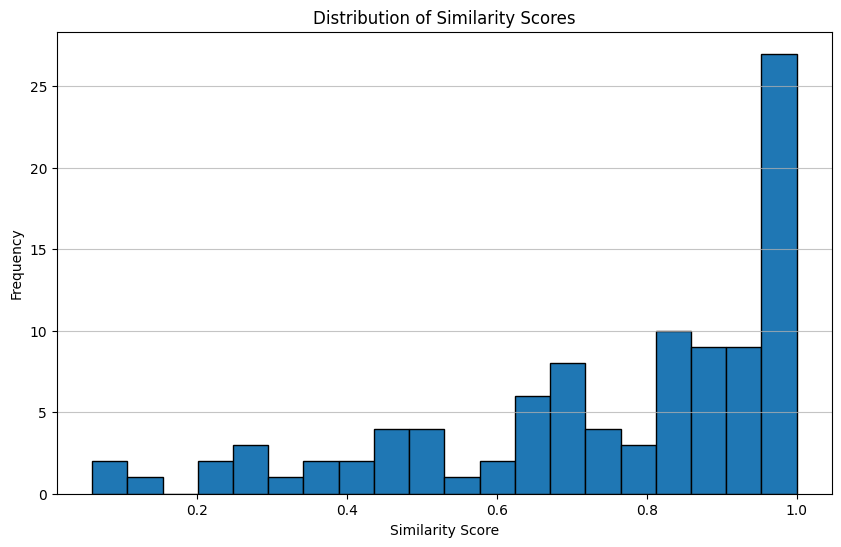

In [38]:
# prompt: plot the similarity score distribution

import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'results_df' is the DataFrame from the previous code cell
# If not, replace 'results_df' with the actual DataFrame variable name.

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(results_df['similarity_score'], bins=20, edgecolor='black')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.grid(axis='y', alpha=0.75)
plt.show()

Average Similarity Score: **0.755**

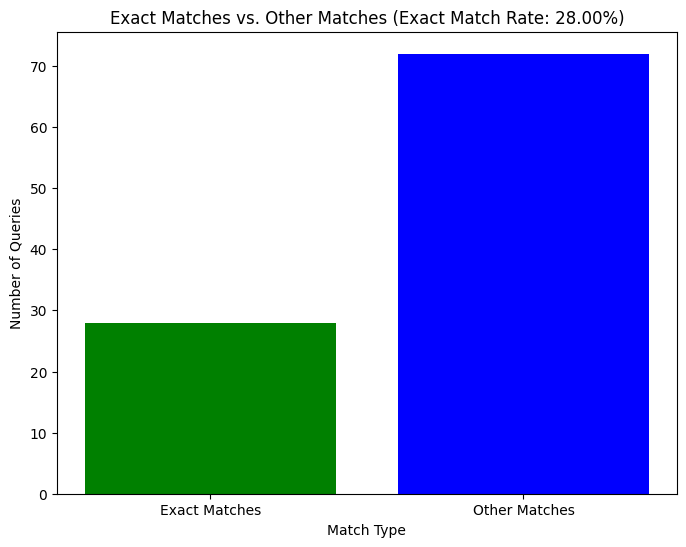

In [39]:
# prompt: plot the exact match

import matplotlib.pyplot as plt

# Assuming 'results_df' is the DataFrame from the previous code cell
# If not, replace 'results_df' with the actual DataFrame variable name.

# Count the number of exact matches
exact_matches = results_df['exact_match'].sum()

# Count the total number of queries
total_queries = len(results_df)

# Calculate the exact match rate
exact_match_rate = exact_matches / total_queries

# Create the plot
plt.figure(figsize=(8, 6))
plt.bar(['Exact Matches', 'Other Matches'], [exact_matches, total_queries - exact_matches], color=['green', 'blue'])
plt.xlabel('Match Type')
plt.ylabel('Number of Queries')
plt.title(f'Exact Matches vs. Other Matches (Exact Match Rate: {exact_match_rate:.2%})')
plt.show()

In [40]:
results_df['prompt_used'].head()

,prompt_used
0,"[INST]\nAs an expert SQL engineer, generate a ..."
1,"[INST]\nAs an expert SQL engineer, generate a ..."
2,"[INST]\nAs an expert SQL engineer, generate a ..."
3,"[INST]\nAs an expert SQL engineer, generate a ..."
4,"[INST]\nAs an expert SQL engineer, generate a ..."
